In [1]:
from pathlib import Path
from tqdm import tqdm
import sys

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst, equilibrate_graphene

In [3]:
# Read setting file
ROOT_DIR = WORK_DIR.parent
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
RES_DIR = WORK_DIR / "results" / f"{partition}_partition"
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)

In [4]:
# DFT data
dft_data = np.loadtxt("../energyvslatconst/dft_data.txt", delimiter=",")

In [5]:
##########################################################################################
# Dropout
# -------

dropout_data = np.load(
    WORK_DIR.parent
    / "training_dropout"
    / "results"
    / "dropout"
    / f"{partition}_partition"
    / "uncertainty_energy_vs_latconst.npz"
)
alist = dropout_data["alist"]
energy_mean_do = dropout_data["energy_mean"]
energy_error_do = dropout_data["energy_error"]

In [6]:
##########################################################################################
# Random initialization
# ---------------------
# Compute the energy ensembles
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    energy_ensembles = preds_data["energy_ensembles"]
else:
    energy_ensembles = np.empty((0, len(alist)))
    for set_idx in tqdm(range(100)):
        # Predictions
        modelname = f"DUNN_C_randinit_{set_idx:03d}"
        _, elist, _ = energyvslatconst(modelname, alist, apply_dropout=False)
        energy_ensembles = np.row_stack((energy_ensembles, elist))
    energy_ensembles = energy_ensembles.astype(float)
    np.savez(preds_samples_file, alist=alist, energy_ensembles=energy_ensembles)

  0%|                                                                          | 0/21 [00:00<?, ?it/s]


 48%|██████████████████████████████▉                                  | 10/21 [00:00<00:00, 12.49it/s]


100%|█████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.77it/s]


 29%|██████████████████▊                                               | 6/21 [00:00<00:01, 12.00it/s]


 67%|███████████████████████████████████████████▎                     | 14/21 [00:01<00:00, 12.78it/s]


  0%|                                                                          | 0/21 [00:00<?, ?it/s]


 48%|██████████████████████████████▉                                  | 10/21 [00:00<00:00, 12.29it/s]


100%|█████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.63it/s]


 29%|██████████████████▊                                               | 6/21 [00:00<00:01, 12.05it/s]


 76%|█████████████████████████████████████████████████▌               | 16/21 [00:01<00:00, 13.05it/s]


 10%|██████▎                                                           | 2/21 [00:00<00:01, 12.46it/s]


 57%|█████████████████████████████████████▏                           | 12/21 [00:00<00:00, 12.67it/s]


 83%|█████████████████████████████████████████████████████           | 83/100 [02:18<00:28,  1.66s/it]


 38%|█████████████████████████▏                                        | 8/21 [00:00<00:01, 12.31it/s]


 86%|███████████████████████████████████████████████████████▋         | 18/21 [00:01<00:00, 12.72it/s]


100%|███████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


In [7]:
energy_mean_ri = np.mean(energy_ensembles, axis=0)
energy_error_ri = np.std(energy_ensembles, axis=0)

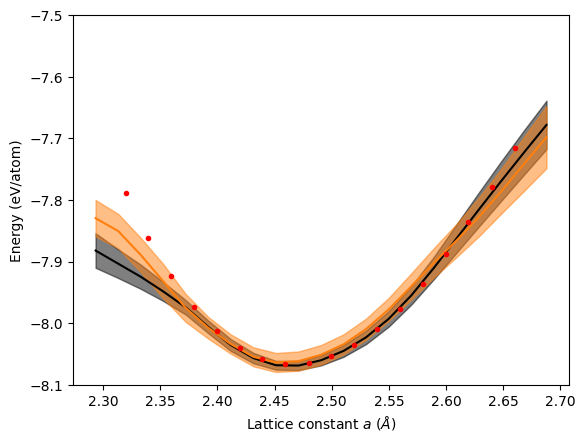

In [8]:
# Plot the result curves
# Energy vs lattice constant
plt.figure()
plt.plot(*(dft_data.T), "r.", zorder=10, label="DFT")

# Random init
plt.fill_between(
    alist,
    energy_mean_ri - energy_error_ri,
    energy_mean_ri + energy_error_ri,
    alpha=0.5,
    color="k",
)
plt.plot(alist, energy_mean_ri, "-", color="k", label="DUNN random init")

# Dropout
plt.fill_between(
    alist,
    energy_mean_do - energy_error_do,
    energy_mean_do + energy_error_do,
    alpha=0.5,
    color="tab:orange",
)
plt.plot(alist, energy_mean_do, "-", color="tab:orange", label="DUNN dropout")
plt.ylim(-8.1, -7.5)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")
# plt.legend()

plt.show()